# Initial EDA & Model Investigation

In this notebook only one dataset will be used to review the change in CPI from 2017 up until April 2023. Each category and the headline will be plotted and reviewed.

To start with univariate models will be fitted to the data and used to predict the different CPI values for April 2023.

Models that might be included are:
- Markov Chain Monte Carlo model
- ARIMA model
- Long Short Term Memory Recurrent neural network (LSTM) model

Initially one model will be used to predict all CPI value for all the categories and the headline CPI. This might change going forward, depending on the performance of the different models.

### Step 1: Import Libraries

Import the following libraries:
- pandas:
    - provides tools for working with structured data.
- numpy:
    - provides powerful numerical computing tools. 
- matplotlib:
    - allows us to create visualizations of our data
- datetime:
    - provides functions for working with dates and times. 
- Import specific functions from the scikit-learn library, including:
    - train_test_split for splitting our data into training and testing sets.
    - mean_squared_error for evaluating the performance of our model.
    - LinearRegression for fitting a linear regression model.
    - StandardScaler for standardizing our data.

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

%matplotlib inline

from datetime import datetime, timedelta


# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error  
# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import StandardScaler

### Step 2: Import the dataset

I will import two data sets:
- `EXCEL - CPI(5 and 8 digit) from Jan 2017 (202304).xlsx`: this will be used to do the EDA and initial prediction of the CPI values.
- `CPI_Historic_Values_Zindi_Mar_23.csv`: this data was provided on the Zindi website and will be used to confirm that the calculations on the raw data is correct.
- `Zindi_CPI_Predictions_April.xlsx`: this data is the example predictions for the April 2023 data on Zindi and will be used to compare the predictions from the simple model.

In [2]:
raw_df = pd.read_excel("EXCEL - CPI(5 and 8 digit) from Jan 2017 (202304).xlsx", dtype="object")
cpi_df= pd.read_csv("CPI_Historic_Values_Zindi_Mar_23.csv")
pred_df = pd.read_excel("Zindi_CPI_Predictions_April.xlsx")

### Step 3: Review the Historical CPI data and Create a Summary DataFrame

In [3]:
raw_df.shape

(225, 84)

There are 12 main categories that are used to calculate the Headline CPI. Each category has a number of sub categories and this data set summarises the information on different levels.

Our aim is to create a single raw data set as well as a dataset summarised on the 12 category level, which will be used in the models to predict the CPI for the different categories as well as the Headline CPI.

In terms of cleaning the data, I will do the following:
- Remove unnecessary columns.
- Change column headers to make them more explanatory.
- Replace all `..` entries with a `0`. 
- Combine the `Super maize` and `Special maize` categories into a single `Maize meal` category, to correspond with the current use of maize meal.
- Create a function to calculate the CPI values for each month used the weights provided in the file.

#### 1. Drop unnecessary columns & rename columns

In [4]:
list_cols_to_drop = ['H01','H02','H05','H06','H07']
cat_cpi_df = raw_df.drop(list_cols_to_drop, axis=1).copy()

In [5]:
cat_cpi_df.rename(columns = {'H03':'category_codes', 'H04':'category_descr', 
                             'Weight (All urban)':'weights_urban'}, inplace = True)

#### 2. Replace all `..` entries with a `0`.

In [6]:
print(cat_cpi_df.dtypes)

category_codes    object
category_descr    object
weights_urban     object
M201701           object
M201702           object
                   ...  
M202212           object
M202301           object
M202302           object
M202303           object
M202304           object
Length: 79, dtype: object


In [7]:
# find all '..' entries in the dataframe
cat_cpi_df[cat_cpi_df.eq('..').any(axis=1)]

,category_codes,category_descr,weights_urban,M201701,M201702,M201703,M201704,M201705,M201706,M201707,...,M202207,M202208,M202209,M202210,M202211,M202212,M202301,M202302,M202303,M202304
15,01116003,Maize meal,0.76,..,..,..,..,..,..,..,...,121.9,127.8,126.2,128.4,131.2,133.7,137.9,141,142.3,142.4
17,01116008,Super maize,..,118.4,119,116.4,112.9,108,104.2,101,...,..,..,..,..,..,..,..,..,..,..
18,01116009,Special maize,..,126,126.2,121.1,116.5,118.8,116.8,104.5,...,..,..,..,..,..,..,..,..,..,..
21,01116012,Samp,0.01,..,..,..,..,..,..,..,...,116.5,119,120.8,120.6,122.9,125.9,130.4,132.7,135.9,134.1
97,01182001,Jam,0.02,..,..,..,..,..,..,..,...,105,107.7,110.8,110.4,110.9,109.6,110.7,110.8,113,112.4
116,01193008,Baby food - pureed bottled/pouched,0.05,..,..,..,..,..,..,..,...,107.7,110.5,111.3,112.8,112.8,112.7,112.9,113.1,113.4,116.5
119,01211003,Cappucino sachets,0.03,..,..,..,..,..,..,..,...,109.8,110.4,111,112.8,113.2,112.3,114.1,115.3,115.8,117.2
129,01223003,Dairy blends/mixtures,0.07,..,..,..,..,..,..,..,...,108.7,110.2,114.9,119.5,121.4,120.4,120.2,122.7,119.9,120.2
137,02122002,Gin,0.10,..,..,..,..,..,..,..,...,106.8,106,107.1,107.8,108,107.3,108.2,107.8,108.9,110.5


There are product which were included in the CPI calculations at a later stage and some products that were removed from the CPI calculation. Categories with no value at the time has a `..`, I will replace them with a `0`. The type of the column can then be updated to float.

In [8]:
cat_cpi_df.replace("..", 0, inplace=True)

In [9]:
cat_cpi_df[cat_cpi_df.eq(0).any(axis=1)]

,category_codes,category_descr,weights_urban,M201701,M201702,M201703,M201704,M201705,M201706,M201707,...,M202207,M202208,M202209,M202210,M202211,M202212,M202301,M202302,M202303,M202304
15,01116003,Maize meal,0.76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,121.9,127.8,126.2,128.4,131.2,133.7,137.9,141.0,142.3,142.4
17,01116008,Super maize,0,118.4,119.0,116.4,112.9,108.0,104.2,101.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,01116009,Special maize,0,126.0,126.2,121.1,116.5,118.8,116.8,104.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,01116012,Samp,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,116.5,119.0,120.8,120.6,122.9,125.9,130.4,132.7,135.9,134.1
97,01182001,Jam,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,105.0,107.7,110.8,110.4,110.9,109.6,110.7,110.8,113.0,112.4
116,01193008,Baby food - pureed bottled/pouched,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,107.7,110.5,111.3,112.8,112.8,112.7,112.9,113.1,113.4,116.5
119,01211003,Cappucino sachets,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,109.8,110.4,111.0,112.8,113.2,112.3,114.1,115.3,115.8,117.2
129,01223003,Dairy blends/mixtures,0.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,108.7,110.2,114.9,119.5,121.4,120.4,120.2,122.7,119.9,120.2
137,02122002,Gin,0.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,106.8,106.0,107.1,107.8,108.0,107.3,108.2,107.8,108.9,110.5


#### 3. Combine the `Maize` categories

In [10]:
cat_cpi_df.shape

(225, 79)

In [11]:
# Convert the Super maize and Special maize row to numeric data types.
# The rows will be dropped, so the loss of other information is not a problem.

cat_cpi_df.iloc[17:19] = cat_cpi_df.iloc[17:19].apply(pd.to_numeric, errors='coerce')

# Divide rows A and B
divided_row = (cat_cpi_df.iloc[17]+cat_cpi_df.iloc[18])/2

# Replace the value in row C if it is 0 with the divided value
cat_cpi_df.iloc[15] = [divided_row[i] if value == 0 else value for i, value in enumerate(cat_cpi_df.iloc[15])]

# Remove the rows for Super maize and Special maize
cat_cpi_df.drop([cat_cpi_df.index[17], cat_cpi_df.index[18]], inplace=True)
print(cat_cpi_df.shape)

(223, 79)


In [12]:
cat_cpi_df.iloc[15, 3:].sum()
# 7844.05

7844.050000000002

In [13]:
# check
cat_cpi_df.iloc[17:19]

,category_codes,category_descr,weights_urban,M201701,M201702,M201703,M201704,M201705,M201706,M201707,...,M202207,M202208,M202209,M202210,M202211,M202212,M202301,M202302,M202303,M202304
19,01116010,Hot cereals (porridge) incl instant porridge,0.05,84.4,83.2,83.8,84.1,84.4,84.9,82.1,...,106.0,111.9,112.3,112.4,114.6,115.5,113.1,116.6,118.4,120.6
20,01116011,Ready-mix flour,0.01,83.2,82.7,83.0,82.6,82.8,82.5,82.5,...,113.2,116.4,116.1,116.0,115.1,115.0,115.9,119.0,118.1,119.3


#### 4. Create a function to calculate the category and headline CPI for each month
Use the logic provided by StatsSA and the weights provided in the data to calculate the CPI for each month.

In [14]:
# Create a category dictionary with the category code and description
category_dict = {"01":"Food and non-alcoholic beverages",
                 "02":"Alcoholic beverages and tobacco",
                 "03":"Clothing and footwear",
                 "04":"Housing and utilities",
                 "05":"Household contents and services",
                 "06":"Health",
                 "07":"Transport",
                 "08":"Communication",
                 "09":"Recreation and culture",
                 "10":"Education",
                 "11":"Restaurants and hotels",
                 "12":"Miscellaneous goods and services"
}
# category_dict

In [15]:
# Convert the 'weights_urban' column to float
cat_cpi_df['weights_urban'] = cat_cpi_df['weights_urban'].astype('float')

In [16]:
def create_monthly_cpi(input_df):
    """Create a dataframe with the headline CPI and category CPI values using the raw data as input"""
    
    # Make a copy of the input dataframe
    df = input_df.copy()
    
    # Assign a main category code to each raw data row.
    main_category = []
    for index, row in cat_cpi_df.iterrows():
        if (len(row['category_codes']) == 8) & (row['category_codes'][:2] in ["01","02"]):
            main_category.append(row['category_codes'][:2])
        elif (len(row['category_codes']) == 5):  # & (row['category_codes'][:2] not in ["04","07"]):
            main_category.append(row['category_codes'][:2])
        else:
            main_category.append("no")
    
    df['main_category_code'] = main_category
    
    # Drop the rows where the main_category_code is "no". That is to prevent double counting.
    # Some categories have a sub category included in the data.
    df.drop(df[df['main_category_code'] == "no"].index, inplace = True)
    
    # Sum the weights for each category
    sum_weights = df.groupby('main_category_code')['weights_urban'].sum()
    
    cpi_df = pd.DataFrame()
    
    # For each month create the headline CPI value and the CPI value per category. 
    for col in range(3, df.shape[1]-1):
        column_name = df.columns[col]
        df['weighted_index_' + column_name] = df['weights_urban']*df[column_name]
    
        sum_weighted_index = df.groupby('main_category_code')['weighted_index_' + column_name].sum()
        
        # Concatenate the DataFrames horizontally
        concat_df = pd.concat([sum_weights, sum_weighted_index], axis=1)
        
        # Add a row that sums the values in the columns
        sums_df = pd.DataFrame(concat_df.sum().values.reshape(1, -1), columns=concat_df.columns)
        sums_df = sums_df.set_index(pd.Index(["headline"]))
        
        # Concatenate the headline dataframe to the categories
        month_cpi_df = pd.concat([concat_df, sums_df], axis=0) 
        
        # Calculate the CPI value
        month_cpi_df['cpi_'+column_name] = (month_cpi_df['weighted_index_' + column_name] / 
                                            month_cpi_df['weights_urban']).round(1)
        
        cpi_df = pd.concat([cpi_df, month_cpi_df[['weights_urban', 'cpi_'+column_name]]], axis=1)
    
    # Remove duplicate weights columns and reset the index
    cpi_df = cpi_df.loc[:, ~cpi_df.columns.duplicated()]
    cpi_df = cpi_df.reset_index().rename(columns={'index':'category'})
    
    # Dataframe with just the CPI values:
    cpi_df = cpi_df.drop('weights_urban', axis=1).copy()
    
    
    
    return(cpi_df)

In [17]:
cpi_summary_df = create_monthly_cpi(cat_cpi_df)

In [18]:
cpi_summary_df

,category,cpi_M201701,cpi_M201702,cpi_M201703,cpi_M201704,cpi_M201705,cpi_M201706,cpi_M201707,cpi_M201708,cpi_M201709,...,cpi_M202207,cpi_M202208,cpi_M202209,cpi_M202210,cpi_M202211,cpi_M202212,cpi_M202301,cpi_M202302,cpi_M202303,cpi_M202304
0,01,81.6,82.2,82.4,82.3,82.7,82.6,82.6,82.3,82.3,...,107.8,109.7,110.3,111.3,112.0,112.4,114.4,115.5,116.7,117.4
1,02,78.5,78.3,79.5,80.1,80.3,80.4,80.6,81.7,82.0,...,104.3,104.7,105.6,106.1,106.4,106.2,106.5,106.9,109.2,110.2
2,03,92.7,93.0,93.3,93.3,93.5,93.5,93.5,93.6,93.7,...,101.6,102.1,102.4,102.7,102.6,102.8,102.9,103.5,103.4,103.7
3,04,82.1,82.1,82.8,82.8,82.8,83.6,84.5,84.5,85.3,...,103.1,103.2,103.8,103.8,103.8,104.1,104.1,104.2,104.5,104.6
4,05,90.5,90.2,90.7,90.5,90.6,91.2,91.1,90.9,91.3,...,103.3,103.6,104.5,105.0,105.2,106.1,106.6,106.6,107.8,107.7
5,06,79.3,82.3,83.0,83.4,83.6,83.8,84.0,83.8,84.0,...,104.1,104.2,104.0,104.5,104.7,104.7,104.9,108.5,109.1,109.5
6,07,76.7,77.3,77.2,77.0,77.8,77.5,76.6,76.9,78.1,...,115.6,114.5,112.0,111.7,113.1,113.9,109.9,110.6,112.9,113.1
7,08,103.7,103.6,102.9,102.9,102.7,102.4,102.3,102.1,101.9,...,99.9,100.1,99.9,99.8,99.2,99.1,99.4,99.8,99.7,99.8
8,09,96.9,97.1,97.2,97.3,97.3,97.4,97.5,97.5,97.3,...,102.4,102.4,102.5,102.7,102.9,103.5,103.5,103.3,104.3,105.0
9,10,74.2,74.2,79.4,79.4,79.4,79.4,79.4,79.4,79.4,...,104.4,104.4,104.4,104.4,104.4,104.4,104.4,104.4,110.4,110.4


In [19]:
# Transpose the dataframe so that each category is a separate column.
transposed_cpi_df = cpi_summary_df.set_index('category').transpose()
transposed_cpi_df

category,01,02,03,04,05,06,07,08,09,10,11,12,headline
cpi_M201701,81.6,78.5,92.7,82.1,90.5,79.3,76.7,103.7,96.9,74.2,88.2,78.4,82.5
cpi_M201702,82.2,78.3,93.0,82.1,90.2,82.3,77.3,103.6,97.1,74.2,89.2,81.6,83.2
cpi_M201703,82.4,79.5,93.3,82.8,90.7,83.0,77.2,102.9,97.2,79.4,89.4,81.7,83.6
cpi_M201704,82.3,80.1,93.3,82.8,90.5,83.4,77.0,102.9,97.3,79.4,89.2,82.0,83.7
cpi_M201705,82.7,80.3,93.5,82.8,90.6,83.6,77.8,102.7,97.3,79.4,88.5,82.0,83.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
cpi_M202212,112.4,106.2,102.8,104.1,106.1,104.7,113.9,99.1,103.5,104.4,107.8,104.9,107.2
cpi_M202301,114.4,106.5,102.9,104.1,106.6,104.9,109.9,99.4,103.5,104.4,106.8,105.4,107.1
cpi_M202302,115.5,106.9,103.5,104.2,106.6,108.5,110.6,99.8,103.3,104.4,108.8,107.7,107.9
cpi_M202303,116.7,109.2,103.4,104.5,107.8,109.1,112.9,99.7,104.3,110.4,109.6,107.8,109.0


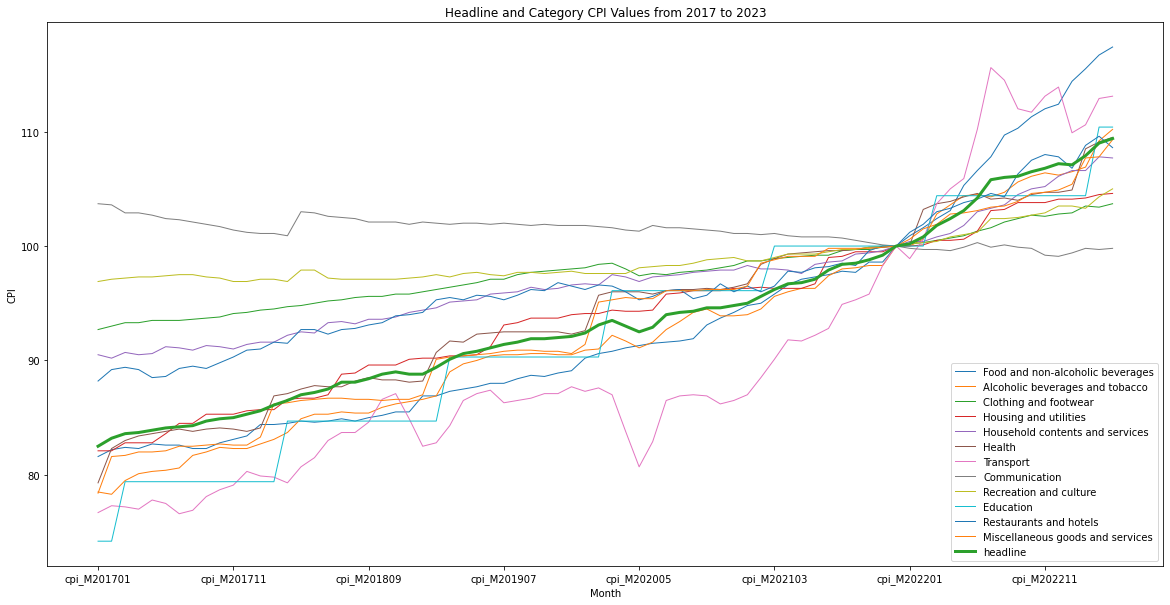

In [20]:
# Plotting the data
ax = transposed_cpi_df.plot.line(linewidth=1, figsize=(20,10))  # Set the default linewidth

# Increasing thickness of a specific line.
ax.lines[12].set_linewidth(3)

# Modify the legend labels
handles, labels = ax.get_legend_handles_labels()
new_labels = [category_dict.get(label, label) for label in labels]
plt.legend(handles, new_labels)

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('CPI')
plt.title('Headline and Category CPI Values from 2017 to 2023')

# Displaying the graph
plt.show()

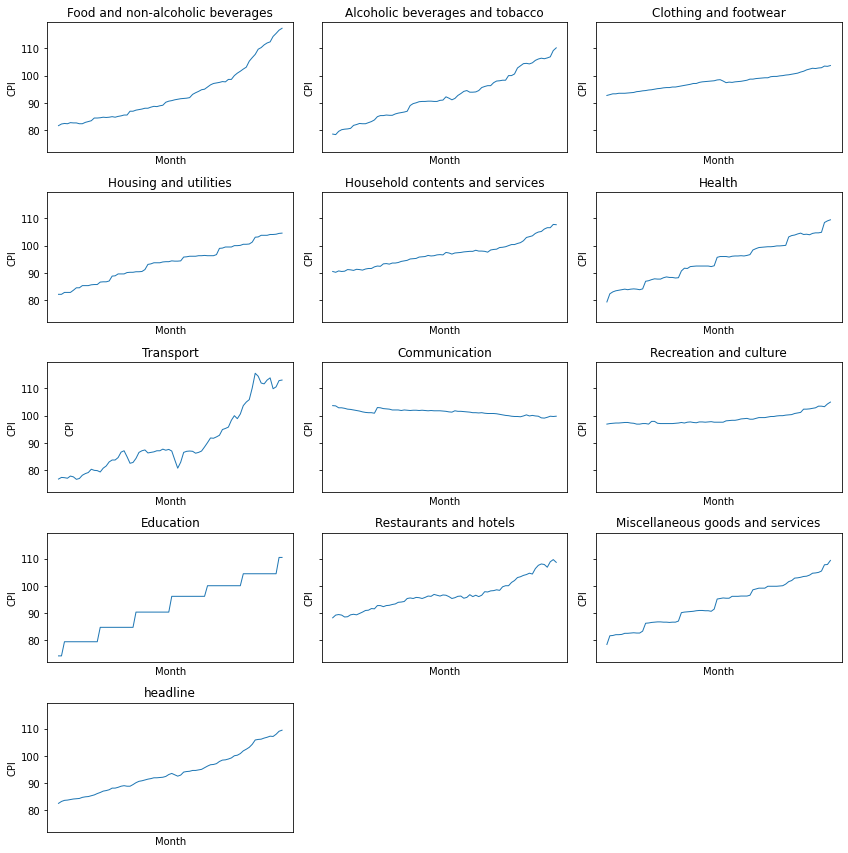

In [21]:
# Plot each category separately to see which categories show the most change over time.
# Determine the number of rows and columns for the grid
n_rows = 5
n_cols = 3

# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 12), sharey=True)

# Iterate over each series and plot on the subplots
for i, column in enumerate(transposed_cpi_df.columns):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    ax.plot(transposed_cpi_df.index, transposed_cpi_df[column], linewidth=1)
    ax.set_title(category_dict.get(column, column))
    ax.set_xlabel('Month')
    ax.set_ylabel('CPI')
    ax.set_xticks([]) 

# Remove unused subplots
for i in range(n_rows * n_cols, len(transposed_cpi_df.columns)):
    fig.delaxes(axes.flatten()[i])

# Set common y-axis label
fig.text(0.08, 0.5, 'CPI', va='center', rotation='vertical')


# Adjust spacing between subplots and remove unused subplots
plt.tight_layout()
fig.delaxes(axes[4, 1])
fig.delaxes(axes[4, 2])

### Create a Markov Chain Monte Carlo model to predict the CPI score

In [22]:
mc_cpi_df = transposed_cpi_df.copy()

In [23]:
# Reset the index so that the row index becomes a column
mc_cpi_df.reset_index(inplace=True)

In [24]:
# Rename category column to 'month' and update the entries by removing the first digits and only keeping the date.
mc_cpi_df.rename(columns = {'index':'year_month'}, inplace = True)
mc_cpi_df['year_month'] = mc_cpi_df['year_month'].str[5:]

In [25]:
# Change format of 'year_month' to a datetime format
mc_cpi_df['year_month'] = pd.to_datetime(mc_cpi_df['year_month'], format='%Y%m')

In [26]:
# Create a function to calculate the predicted CPI value for each category for the next month using a MCMC model.
cpi_dict = {}

def predict_cpi_with_mcmc(df):
    column_names = df.columns[1:]

    # Iterate through the selected categories
    for column_name in column_names:
        column_data = df[column_name]
        
        cat_df = df[['year_month', column_name]]
        
        # Set the random seed
        np.random.seed(111)
        
        # Define the MCMC model.
        with pm.Model() as model:
            # Priors
            alpha = pm.Normal('alpha', mu=0, sd=10)
            beta = pm.Normal('beta', mu=0, sd=10)
            sigma = pm.HalfCauchy('sigma', beta=10)

            # Convert date to integer values for modeling
            x = (cat_df['year_month'] - cat_df['year_month'].min()).dt.days.values

            # Regression model
            mu = alpha + beta * x
            y = pm.Normal('y', mu=mu, sd=sigma, observed=cat_df[column_name])

            # Sampling
            trace = pm.sample(1500, tune=1500)
            
            # Visualize the results
#             pm.traceplot(trace)
#             plt.show()
#             pm.plot_posterior(trace)
#             plt(.show)
            
            # Generate posterior predictive samples
            ppc = pm.sample_posterior_predictive(trace, model=model, samples=1500)

            # Plot the observed data
            plt.scatter(cat_df['year_month'], cat_df[column_name], label='Observed')

            # Plot the posterior predictive samples
            for i in range(ppc['y'].shape[0]):
                plt.plot(cat_df['year_month'], ppc['y'][i], color='gray', alpha=0.1)

            plt.xlabel('Date')
            plt.ylabel('Value')
            plt.title('Posterior Predictive Samples')
            plt.legend()
            plt.show()
            
            # Extract the last predicted value
            last_predicted_value = ppc['y'][:, -1]

            # Compute the mean of the last predicted value
            predicted_cpi = last_predicted_value.mean()
            
            cpi_dict[column_name] = predicted_cpi

            print(column_name, predicted_cpi)
    
    

In [27]:
# mc_cpi_df.drop(index=mc_cpi_df.index[:48])

In [28]:
import warnings

# Filter out PyMC3 warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 35 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.658327057706058, but should be close to 0.8. Try to increase the number of tuning steps.


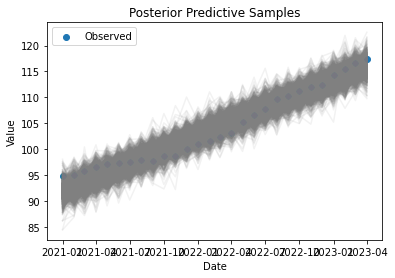

01 116.03229324153854


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 33 seconds.


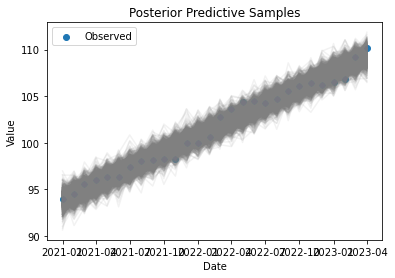

02 109.30339496439288


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 33 seconds.


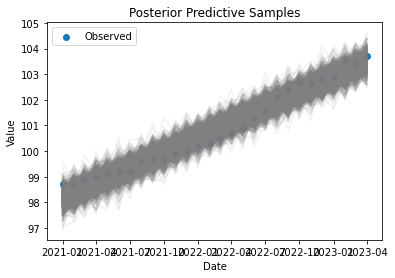

03 103.48744401241878


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 33 seconds.
The acceptance probability does not match the target. It is 0.8829518839648257, but should be close to 0.8. Try to increase the numb

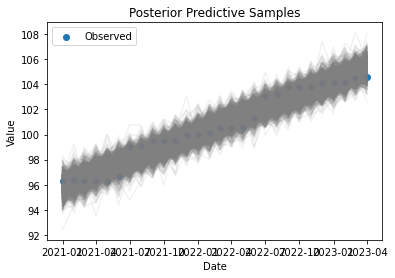

04 105.31233668617145


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 34 seconds.


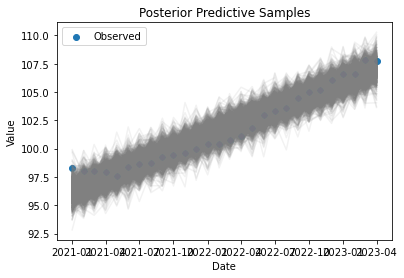

05 107.10128304159048


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 34 seconds.


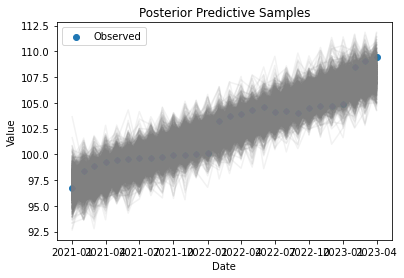

06 107.83254929366605


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 33 seconds.


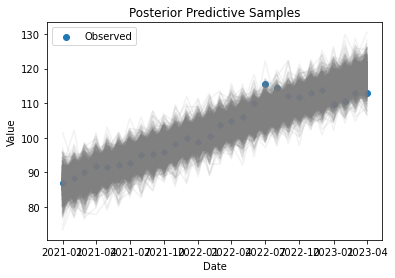

07 117.65520847950238


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 34 seconds.
The acceptance probability does not match the target. It is 0.8876293665328345, but should be close to 0.8. Try to increase the numb

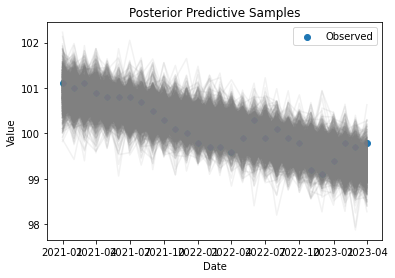

08 99.33262505779696


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 32 seconds.
The acceptance probability does not match the target. It is 0.7054509094036727, but should be close to 0.8. Try to increase the number of tuning steps.


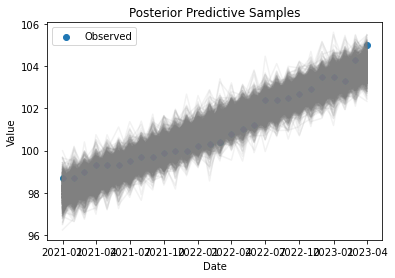

09 103.9853262849818


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 33 seconds.
The acceptance probability does not match the target. It is 0.8856906518413801, but should be close to 0.8. Try to increase the numb

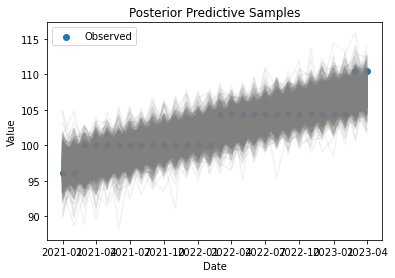

10 107.62281491564381


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 32 seconds.


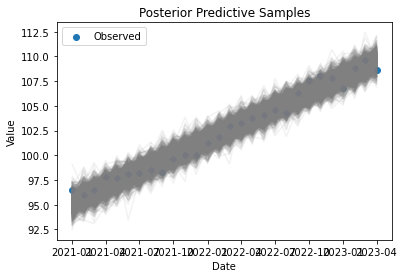

11 109.47140869628953


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 33 seconds.
The acceptance probability does not match the target. It is 0.666301384408197, but should be close to 0.8. Try to increase the number of tuning steps.


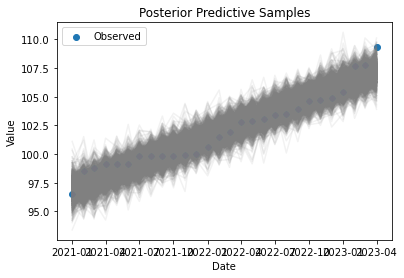

12 107.18520566715394


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/elmarie/anaconda3/envs/rmb_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 33 seconds.


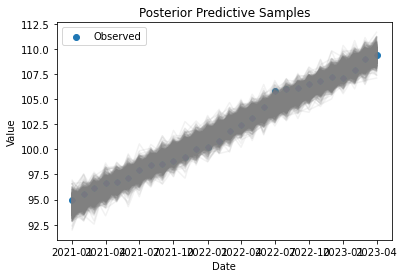

headline 109.38177088029104


In [29]:
# Use data from 2021-2023 fro predictions
predict_cpi_with_mcmc(mc_cpi_df.drop(index=mc_cpi_df.index[:48]))

In [30]:
# Reset the warning filters
warnings.resetwarnings()

In [31]:
# cpi_dict

{'01': 116.03229324153854,
 '02': 109.30339496439288,
 '03': 103.48744401241878,
 '04': 105.31233668617145,
 '05': 107.10128304159048,
 '06': 107.83254929366605,
 '07': 117.65520847950238,
 '08': 99.33262505779696,
 '09': 103.9853262849818,
 '10': 107.62281491564381,
 '11': 109.47140869628953,
 '12': 107.18520566715394,
 'headline': 109.38177088029104}

In [32]:
prediction_df = pd.DataFrame(list(cpi_dict.items()), columns=['ID', 'Value'])
# prediction_df

In [33]:
# Create a dictionary to update the category names to allow a submission to Zindi.
month="May"
pred_category_dict = {"01":month+"_food and non-alcoholic beverages",
                      "02":month+"_alcoholic beverages and tobacco",
                      "03":month+"_clothing and footwear",
                      "04":month+"_housing and utilities",
                      "05":month+"_household contents and services",
                      "06":month+"_health",
                      "07":month+"_transport",
                      "08":month+"_communication",
                      "09":month+"_recreation and culture",
                      "10":month+"_education",
                      "11":month+"_restaurants and hotels",
                      "12":month+"_miscellaneous goods and services",
                      "headline":month+"_headline CPI"
}

In [34]:
prediction_df = prediction_df.replace(pred_category_dict)
prediction_df

,ID,Value
0,May_food and non-alcoholic beverages,116.032293
1,May_alcoholic beverages and tobacco,109.303395
2,May_clothing and footwear,103.487444
3,May_housing and utilities,105.312337
4,May_household contents and services,107.101283
5,May_health,107.832549
6,May_transport,117.655208
7,May_communication,99.332625
8,May_recreation and culture,103.985326
9,May_education,107.622815


Output to excel file:

In [36]:
prediction_df.to_csv('v1_mcmc.csv', index = 0)